In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchtext
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix
import pickle
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import src.helpers as hlp

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
VECT_DIM = 50

## Import

In [3]:
t_pos = pd.read_table("data/train_pos.txt", header=None, names=['tweet'], dtype=str,on_bad_lines='skip')
t_pos['label'] = 1
t_neg = pd.read_table("data/train_neg.txt", header=None, names=['tweet'], dtype=str,on_bad_lines='skip')
t_neg['label'] = 0
df = pd.concat((t_pos,t_neg))

## Processing

In [4]:
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_stopwords(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_punct(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.add_space(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_white_space(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_words_digits(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.to_lower(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_specific_words(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_repeating_char(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_single_char(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.lemmatize(x))

In [5]:
df['tweet'].to_csv('processed_tweets.txt', index=False, header=False)
df[df['label'] == 0]['tweet'].to_csv('processed_tweets_neg.txt', index=False, header=False)
df[df['label'] == 1]['tweet'].to_csv('processed_tweets_pos.txt', index=False, header=False)

In [6]:
vocab = dict()
with open("vocab_processed_cut.txt") as f:
    for idx, line in enumerate(f):
        vocab[line.strip()] = idx

with open("vocab_processed.pkl", "wb") as f:
    pickle.dump(vocab, f, pickle.HIGHEST_PROTOCOL)

In [7]:
with open("vocab_processed.pkl", "rb") as f:
    vocab = pickle.load(f)

data, row, col = [], [], []
counter = 1
for fn in ["processed_tweets_pos.txt", "processed_tweets_neg.txt"]:
    with open(fn) as f:
        for line in f:
            tokens = [vocab.get(t, -1) for t in line.strip().split()]
            tokens = [t for t in tokens if t >= 0]
            for t in tokens:
                for t2 in tokens:
                    data.append(1)
                    row.append(t)
                    col.append(t2)

            if counter % 10000 == 0:
                print(counter)
            counter += 1
cooc = coo_matrix((data, (row, col)))
print("summing duplicates (this can take a while)")
cooc.sum_duplicates()
with open("data/cooc.pkl", "wb") as f:
    pickle.dump(cooc, f, pickle.HIGHEST_PROTOCOL)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
summing duplicates (this can take a while)


In [8]:
from scipy.sparse import *
import numpy as np
import pickle
import random


print("loading cooccurrence matrix")
with open("data/cooc_processed.pkl", "rb") as f:
    cooc = pickle.load(f)
print("{} nonzero entries".format(cooc.nnz))

nmax = 100
print("using nmax =", nmax, ", cooc.max() =", cooc.max())

print("initializing embeddings")
embedding_dim = 50
xs = np.random.normal(size=(cooc.shape[0], embedding_dim))
ys = np.random.normal(size=(cooc.shape[1], embedding_dim))

eta = 0.001
alpha = 3 / 4

epochs = 5

for epoch in range(epochs):
    print("epoch {}".format(epoch))
    for ix, jy, n in zip(cooc.row, cooc.col, cooc.data):
        logn = np.log(n)
        fn = min(1.0, (n / nmax) ** alpha)
        x, y = xs[ix, :], ys[jy, :]
        scale = 2 * eta * fn * (logn - np.dot(x, y))
        xs[ix, :] += scale * y
        ys[jy, :] += scale * x
np.save("embeddings_sample", xs)


loading cooccurrence matrix
5046744 nonzero entries
using nmax = 100 , cooc.max() = 31435
initializing embeddings
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4


In [14]:
embeddings = np.load("embeddings_sample.npy")

In [18]:
def vectorize(tweets):
    vectorized_tweets_np = np.zeros((len(tweets),VECT_DIM))
    for i, tweet in enumerate(tqdm(tweets)):
        tweet_len = len(tweet.split(' '))
        tweet_embedding=np.zeros((tweet_len,VECT_DIM))
        for j, word in enumerate(tweet.split(' ')):
            if word not in vocab.keys():
                continue
            tweet_embedding[j] = embeddings[vocab[word]]
        vectorized_tweets_np[i] = tweet_embedding.mean(0)
    return vectorized_tweets_np

In [19]:
X = vectorize(df.tweet)
y = df['label'].values

100%|██████████| 196970/196970 [00:08<00:00, 24165.04it/s]


In [20]:
X.shape

(196970, 50)

In [21]:
class TrainDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
    
    def __getitem__(self, index):
        return self.y_data[index], self.X_data[index] 

    def __len__(self):
        return len(self.X_data)

In [22]:
class TestDataset(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data
    
    def __getitem__(self, index):
        return self.X_data[index]

    def __len__(self):
        return len(self.X_data)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)

In [24]:
train_data = TrainDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
test_data = TrainDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test))

In [25]:
train_loader = DataLoader(dataset=train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [26]:
def train_loop(dataloader, model, loss_fn, optimizer):
        train_loss, correct = 0,0
        for y_batch, X_batch in tqdm(dataloader):

                pred = model(X_batch)
                loss = loss_fn(pred, y_batch)

                train_loss += loss.item()
                correct += (pred.argmax(1) == y_batch).type(torch.float).sum().item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        train_loss /= len(dataloader)
        correct /= len(dataloader.dataset)
        print(f"Train Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")
        return train_loss, correct

In [27]:
def test_loop(dataloader, model, loss_fn):
    test_loss, correct = 0,0
    with torch.no_grad():
        for y, X in dataloader:

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct



In [28]:
def train(model, train_loader, valid_loader, num_epochs, learning_rate):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_accs, test_accs = [], [], []
    for epoch in range(num_epochs):
        print(f"Epoch : {epoch+1}\n")
        train_loss, train_acc = train_loop(train_loader, model, loss_fn, optimizer)
        test_loss, test_acc = test_loop(test_loader, model, loss_fn)
        losses.append(float(train_loss))
        train_accs.append(train_acc)
        test_accs.append(test_acc)
    
    plt.title("Training")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(train_accs, label="Train")
    plt.plot(test_accs, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()



In [32]:
model = nn.Sequential(nn.Linear(50, 40),
                        nn.Sigmoid(),
                        nn.Linear(40, 20),
                        nn.Sigmoid(),
                        nn.Linear(20, 2))

Epoch : 1



100%|██████████| 1232/1232 [00:04<00:00, 254.49it/s]


Train Error: 
 Accuracy: 60.7%, Avg loss: 0.659137 

Test Error: 
 Accuracy: 61.7%, Avg loss: 0.653252 

Epoch : 2



100%|██████████| 1232/1232 [00:04<00:00, 260.78it/s]


Train Error: 
 Accuracy: 61.5%, Avg loss: 0.648959 

Test Error: 
 Accuracy: 61.7%, Avg loss: 0.645524 

Epoch : 3



100%|██████████| 1232/1232 [00:04<00:00, 266.49it/s]


Train Error: 
 Accuracy: 62.1%, Avg loss: 0.640189 

Test Error: 
 Accuracy: 62.6%, Avg loss: 0.636010 

Epoch : 4



100%|██████████| 1232/1232 [00:04<00:00, 275.18it/s]


Train Error: 
 Accuracy: 63.0%, Avg loss: 0.631002 

Test Error: 
 Accuracy: 63.0%, Avg loss: 0.631447 

Epoch : 5



100%|██████████| 1232/1232 [00:04<00:00, 264.49it/s]


Train Error: 
 Accuracy: 63.6%, Avg loss: 0.625037 

Test Error: 
 Accuracy: 63.4%, Avg loss: 0.627041 

Epoch : 6



100%|██████████| 1232/1232 [00:05<00:00, 236.35it/s]


Train Error: 
 Accuracy: 64.1%, Avg loss: 0.620355 

Test Error: 
 Accuracy: 63.6%, Avg loss: 0.624040 

Epoch : 7



100%|██████████| 1232/1232 [00:06<00:00, 192.85it/s]


Train Error: 
 Accuracy: 64.4%, Avg loss: 0.616163 

Test Error: 
 Accuracy: 63.8%, Avg loss: 0.622156 

Epoch : 8



100%|██████████| 1232/1232 [00:05<00:00, 229.20it/s]


Train Error: 
 Accuracy: 64.7%, Avg loss: 0.613492 

Test Error: 
 Accuracy: 63.8%, Avg loss: 0.623268 

Epoch : 9



100%|██████████| 1232/1232 [00:05<00:00, 221.61it/s]


Train Error: 
 Accuracy: 64.8%, Avg loss: 0.611016 

Test Error: 
 Accuracy: 64.0%, Avg loss: 0.620433 

Epoch : 10



100%|██████████| 1232/1232 [00:04<00:00, 249.99it/s]


Train Error: 
 Accuracy: 65.2%, Avg loss: 0.608462 

Test Error: 
 Accuracy: 64.1%, Avg loss: 0.620849 



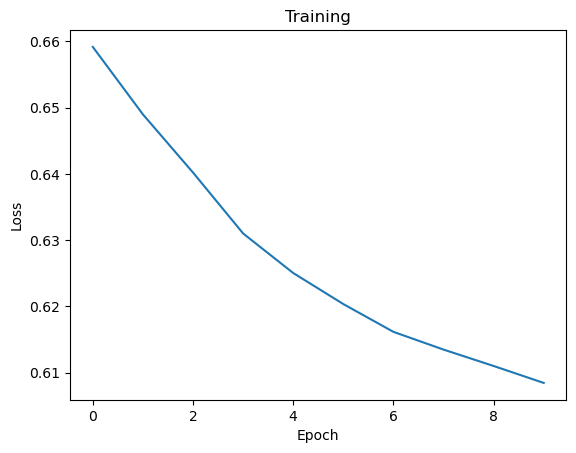

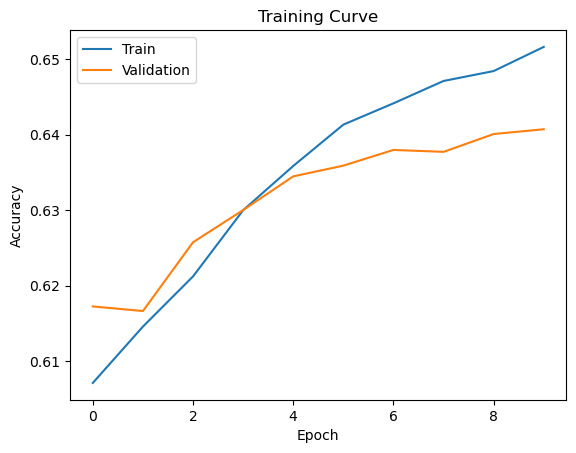

In [33]:
train(model, train_loader, test_loader, num_epochs=10, learning_rate=1e-2)